In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
mpl.rcParams['figure.figsize'] = [10, 7]
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 17

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.3

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.family'] = 'DeJavu Serif'
mpl.rcParams['text.usetex'] = True

In [4]:
BPATH = "/home/dan/edu/uni/diplomka/tex/Images/charted/"

# Global plot func

In [5]:
import os

def savef(name):
    plt.tight_layout()
    plt.savefig(os.path.join(BPATH, name))

In [6]:
N = 250
SEED = 123

In [7]:
from kfsims.trajectory import trajectory
trj = trajectory(SEED, N)
true_traj = trj.X.T
cov_traj = trj.R
cov_init = cov_traj

In [8]:
from kfsims import noise
from kfsims.network import create_w_nodes, create_nodes
import numpy as np

np.random.seed(SEED)

# Nodes noise

In [64]:
nodes = create_nodes(3, trj, cov_init)

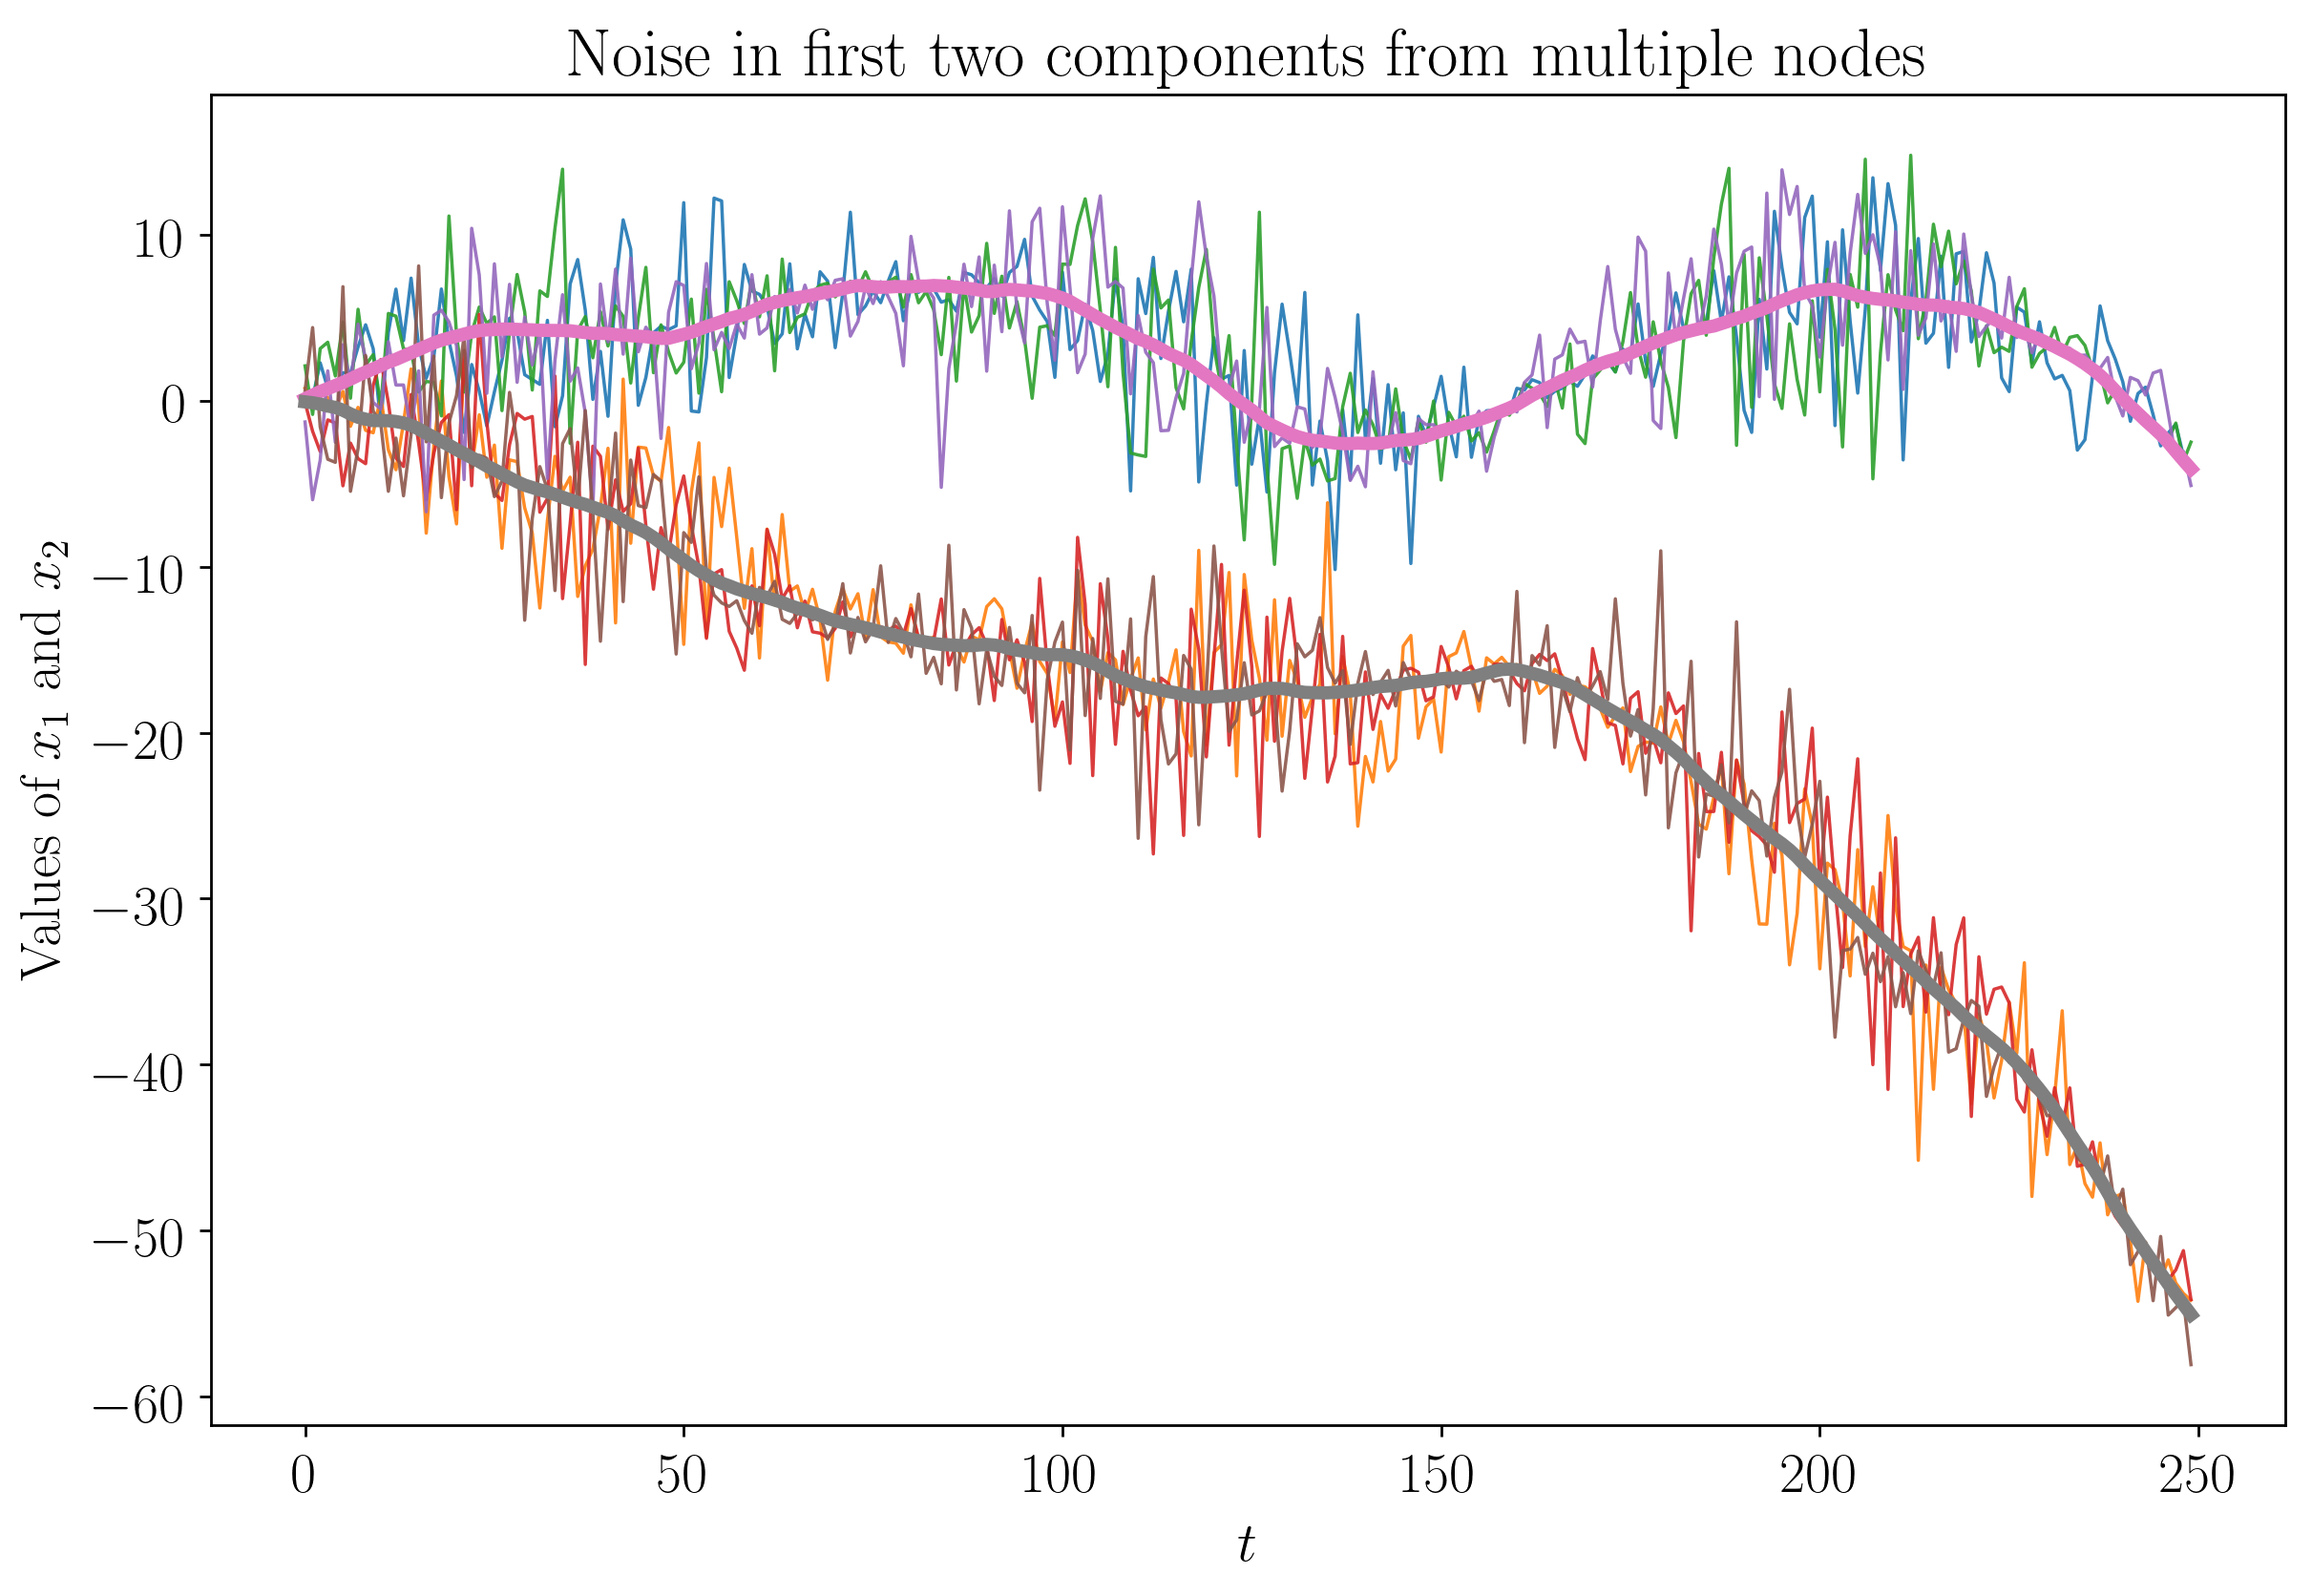

In [65]:
for j,i in enumerate(nodes[:5]):
    plt.plot(list(i.observe()), label=f'Node {j}', 
             lw=1, alpha=0.9)
plt.plot(trj.X[:2,:].T, lw=4, label='True')
plt.ylabel('Values of $x_1$ and $x_2$')
plt.xlabel('$t$')
plt.title('Noise in first two components from multiple nodes')
#plt.legend()
savef('diffusion-noise.pdf')

# Fixed nodes

In [75]:
NODES = 15
MAX_STEP = 1000
STEP = 99
gi = lambda: np.random.randint(0, 100000)
SEED_MOD = 83231 #gi()

In [152]:
def fixed_nodes_it(f, n_nodes, mod_seed, cov, mxi=MAX_STEP, step=STEP):
    res_nd_m = []
    res_nd_s = []
    for i in range(1, mxi, step): 
        G = create_w_nodes(n_nodes, trj,  cov, i)
        m, s = getattr(G, f)(true_traj.T)
        res_nd_m.append(m)
        res_nd_s.append(s)
    return np.array(res_nd_m), np.array(res_nd_s)

In [153]:
%%time
no_diff_m, no_diff_s = fixed_nodes_it(
    'kf_no_diffusion', NODES, SEED_MOD)

CPU times: user 44.7 s, sys: 36.4 ms, total: 44.7 s
Wall time: 45 s


In [ ]:
%%time
diff_m, diff_s = fixed_nodes_it(
    'kf_w_diffusion', NODES, SEED_MOD)

In [ ]:
np.mean(no_diff_m, axis=0)

In [ ]:
np.mean(no_diff_s, axis=0)

In [ ]:
((no_diff_m - diff_m) < 0).any(axis=1)

In [ ]:
np.mean(diff_m, axis=0)

In [ ]:
np.mean(diff_s, axis=0)

In [ ]:
from kfsims.utils import hists_subplots

In [ ]:
import pandas as pd
import seaborn as sns

dt = np.concatenate([np.mean(no_diff_m, axis=0), np.mean(diff_m, axis=0)])
dts = np.concatenate([np.mean(no_diff_s, axis=0), np.mean(diff_s, axis=0)])

df = pd.DataFrame(
    {'RMSE': dt,
     'STD': dts,
     'Component': [f'$x_{i}$' for i in range(1, 5)]*2,
     'Algorithm': ['Diffusion']*4 + ['No diffusion']*4,
    })

n_runs = round(MAX_STEP/STEP)
assert n_runs == 10

#sns.barplot(x='Component', y='Mean RMSE', data=df, hue='Diffusion')
#plt.title(f'Mean RMSE over {n_runs} run variant comparison')
#savef('difnodif-mean-rmse.pdf')

In [ ]:
ax1, ax2 = hists_subplots(df, 'diffused and non-diffused algorithm', legpos='lower right')
ax1.set_title('Mean RMSE', fontsize=15)
ax2.set_title('Mean Standard Deviation', fontsize=15)
savef('rmse-std-diffnodiff.pdf')

# Topology

In [100]:
G = create_w_nodes(NODES, trj,  cov_init, 1)
G.kf_w_diffusion(trj.X)

(array([1.0356, 0.9591, 1.4465, 1.2133]),
 array([0.8782, 0.8469, 1.5745, 1.2348]))

In [101]:
import networkx as nx

/home/dan/.local/opt/miniconda/envs/kalman/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


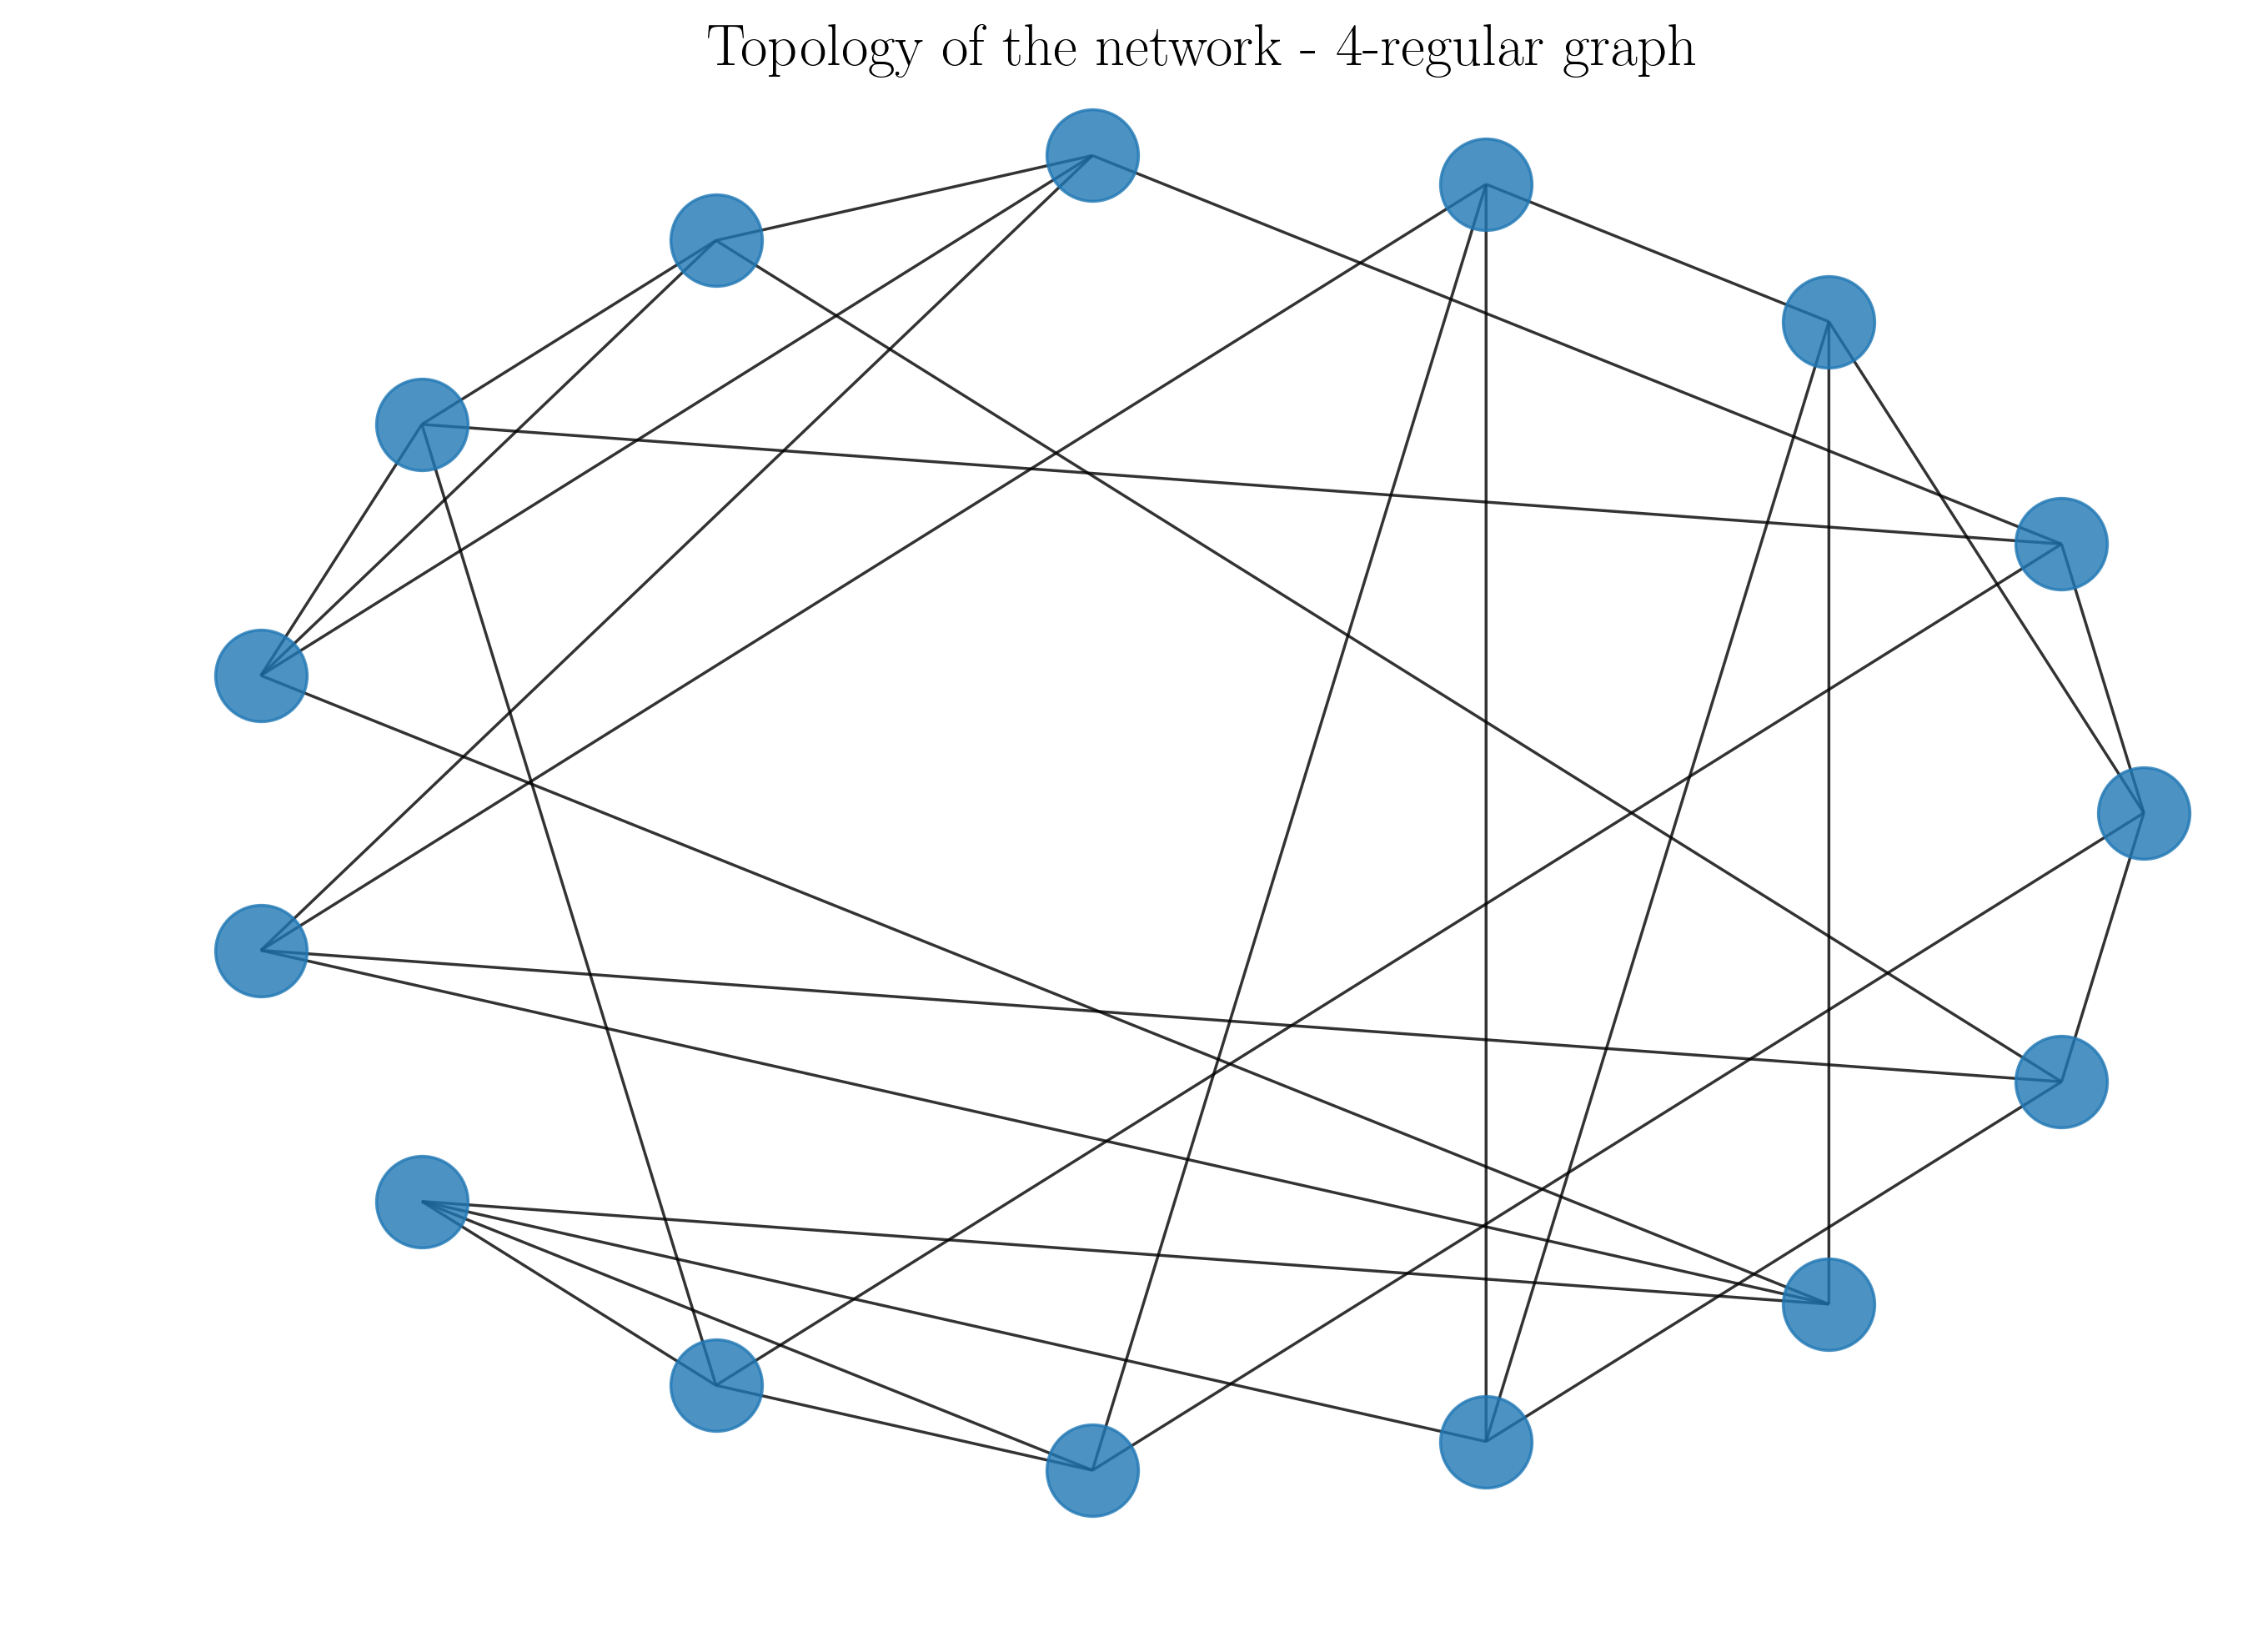

In [102]:
nx.draw_shell(G, node_color='#1f77b4', node_size=1000, 
              alpha=0.8)
plt.title('Topology of the network - 4-regular graph')
savef('network-top.pdf')

# Fixed nodes - single node analysis

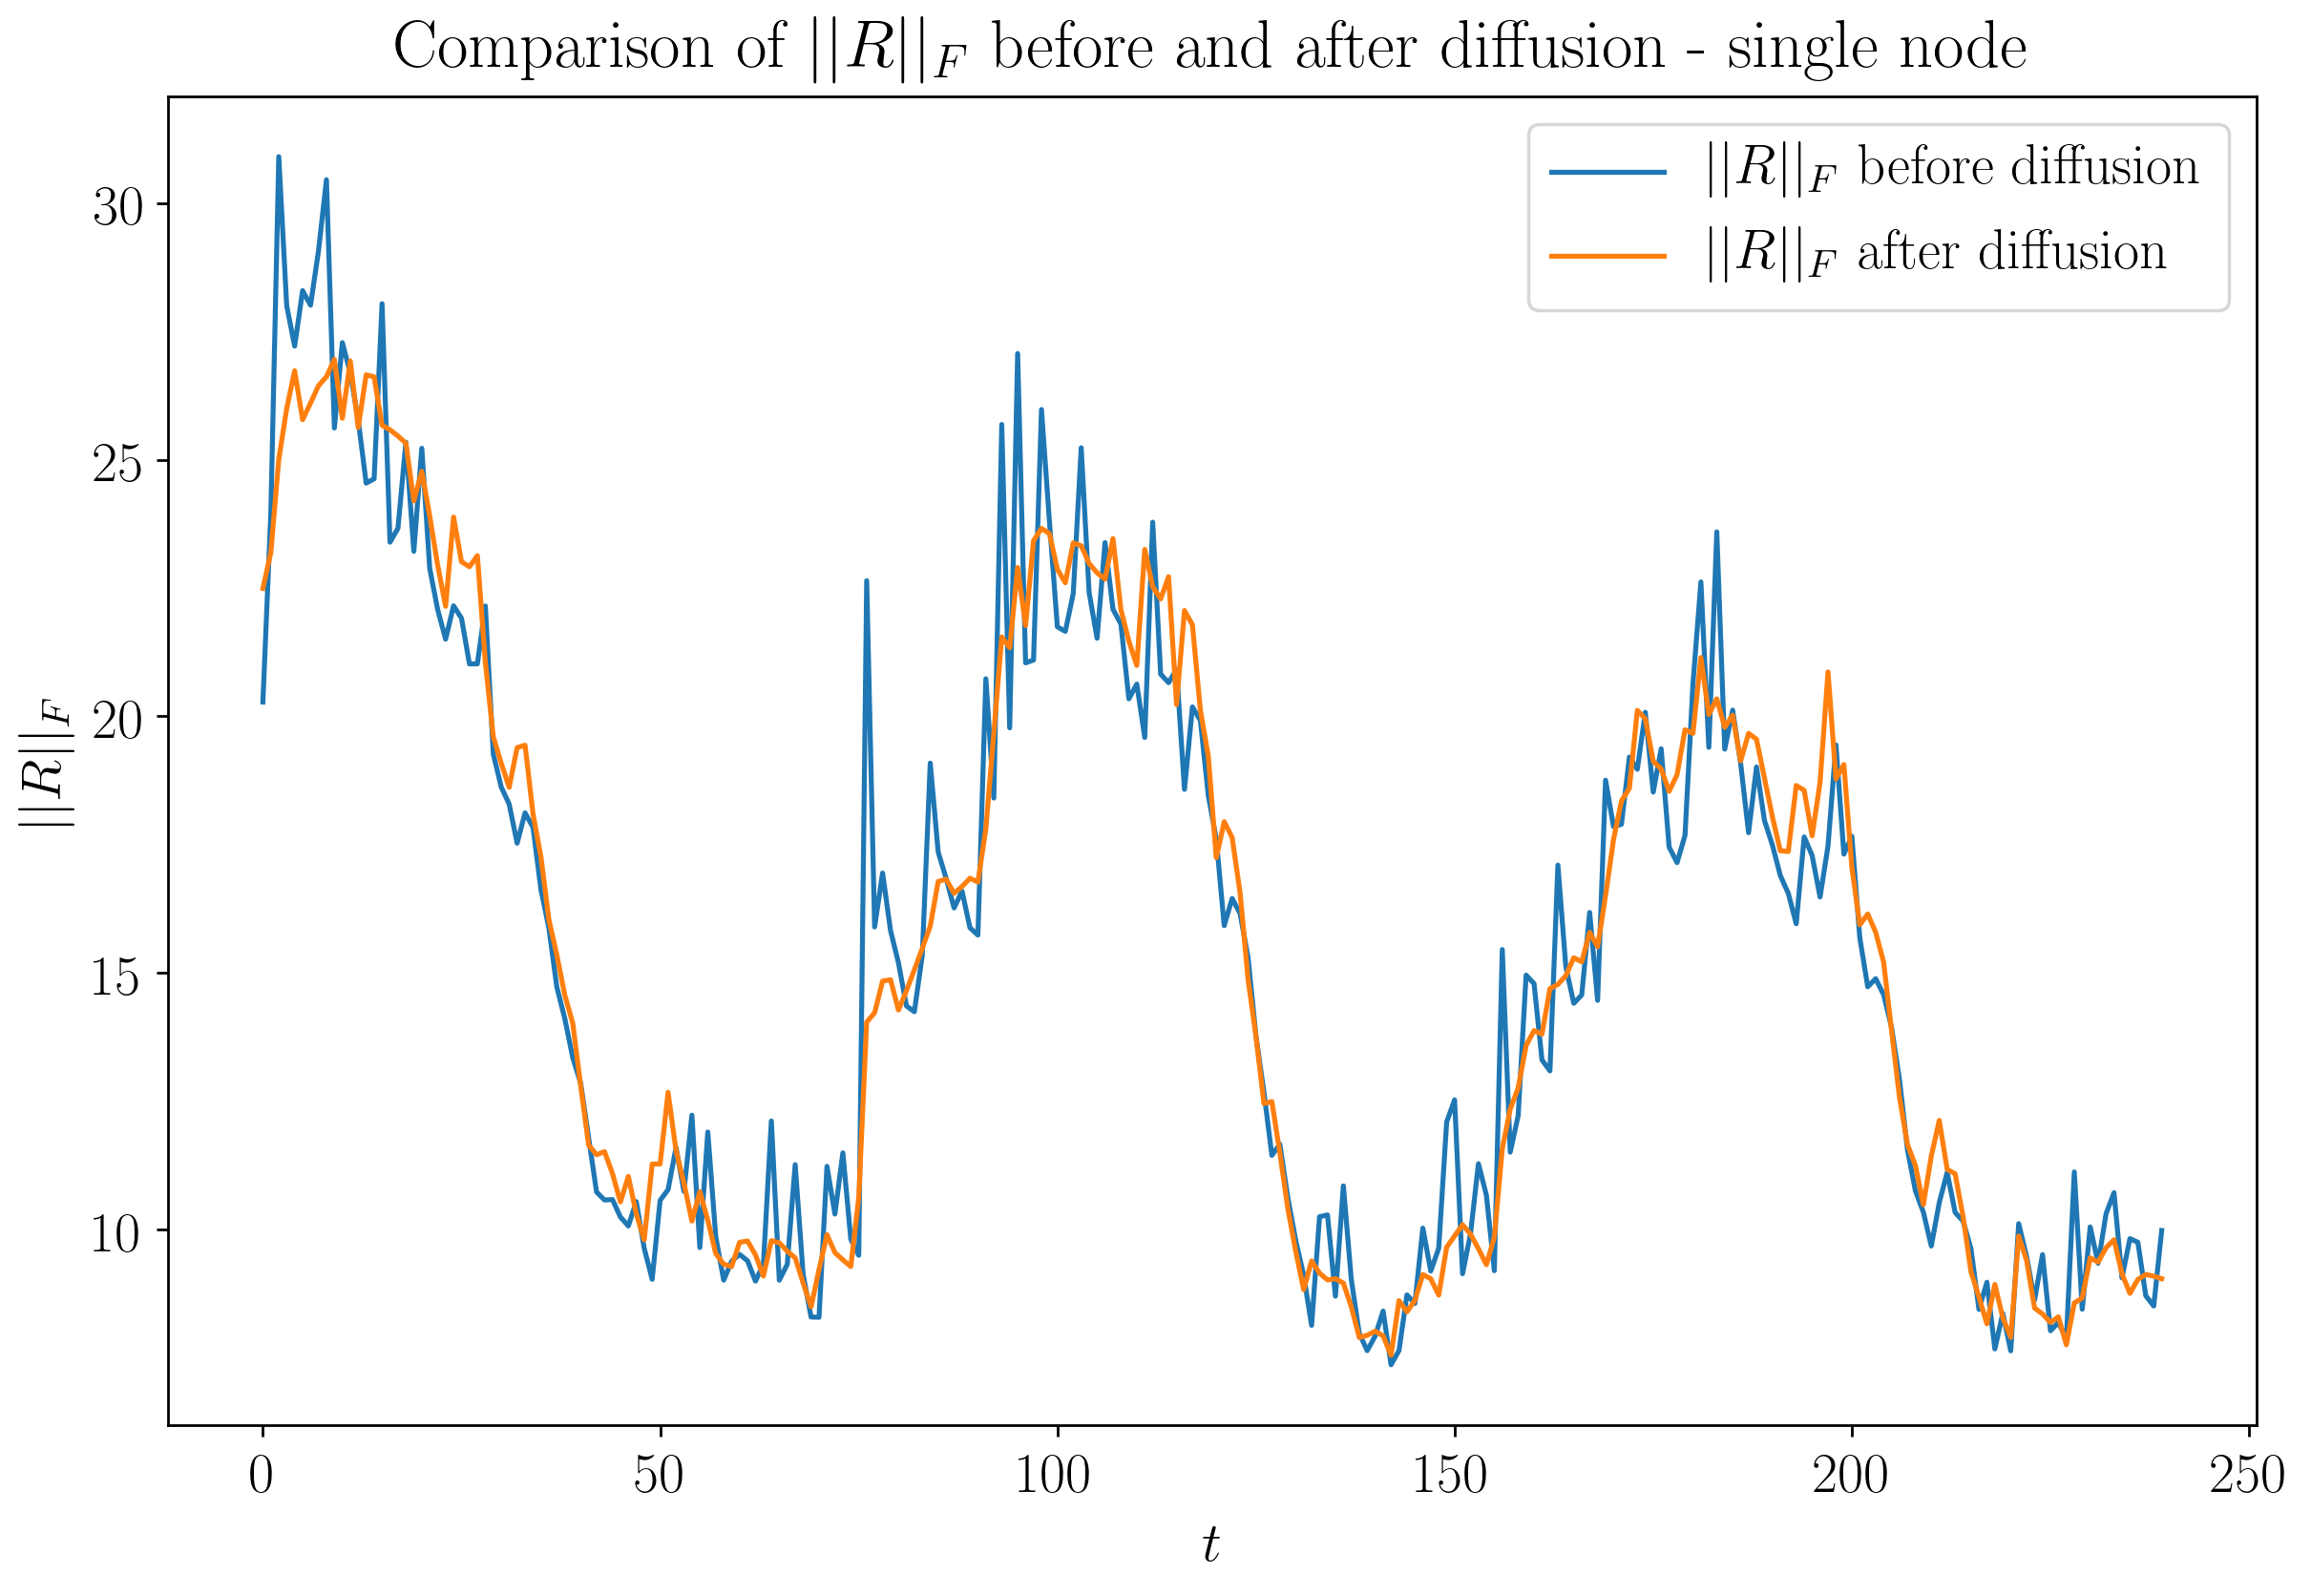

In [110]:
n = list(G.nodes)[2]
r_post_f = np.array([np.linalg.norm(x) for x in n.logger['R_post']])

plt.plot(n.norm_r()[10:], label='$||R||_F$ before diffusion')
plt.plot(r_post_f[10:], label='$||R||_F$ after diffusion')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$||R||_F$')
plt.title('Comparison of $||R||_F$ before and after diffusion - single node')
savef('compare-single-node-r-diff.pdf')

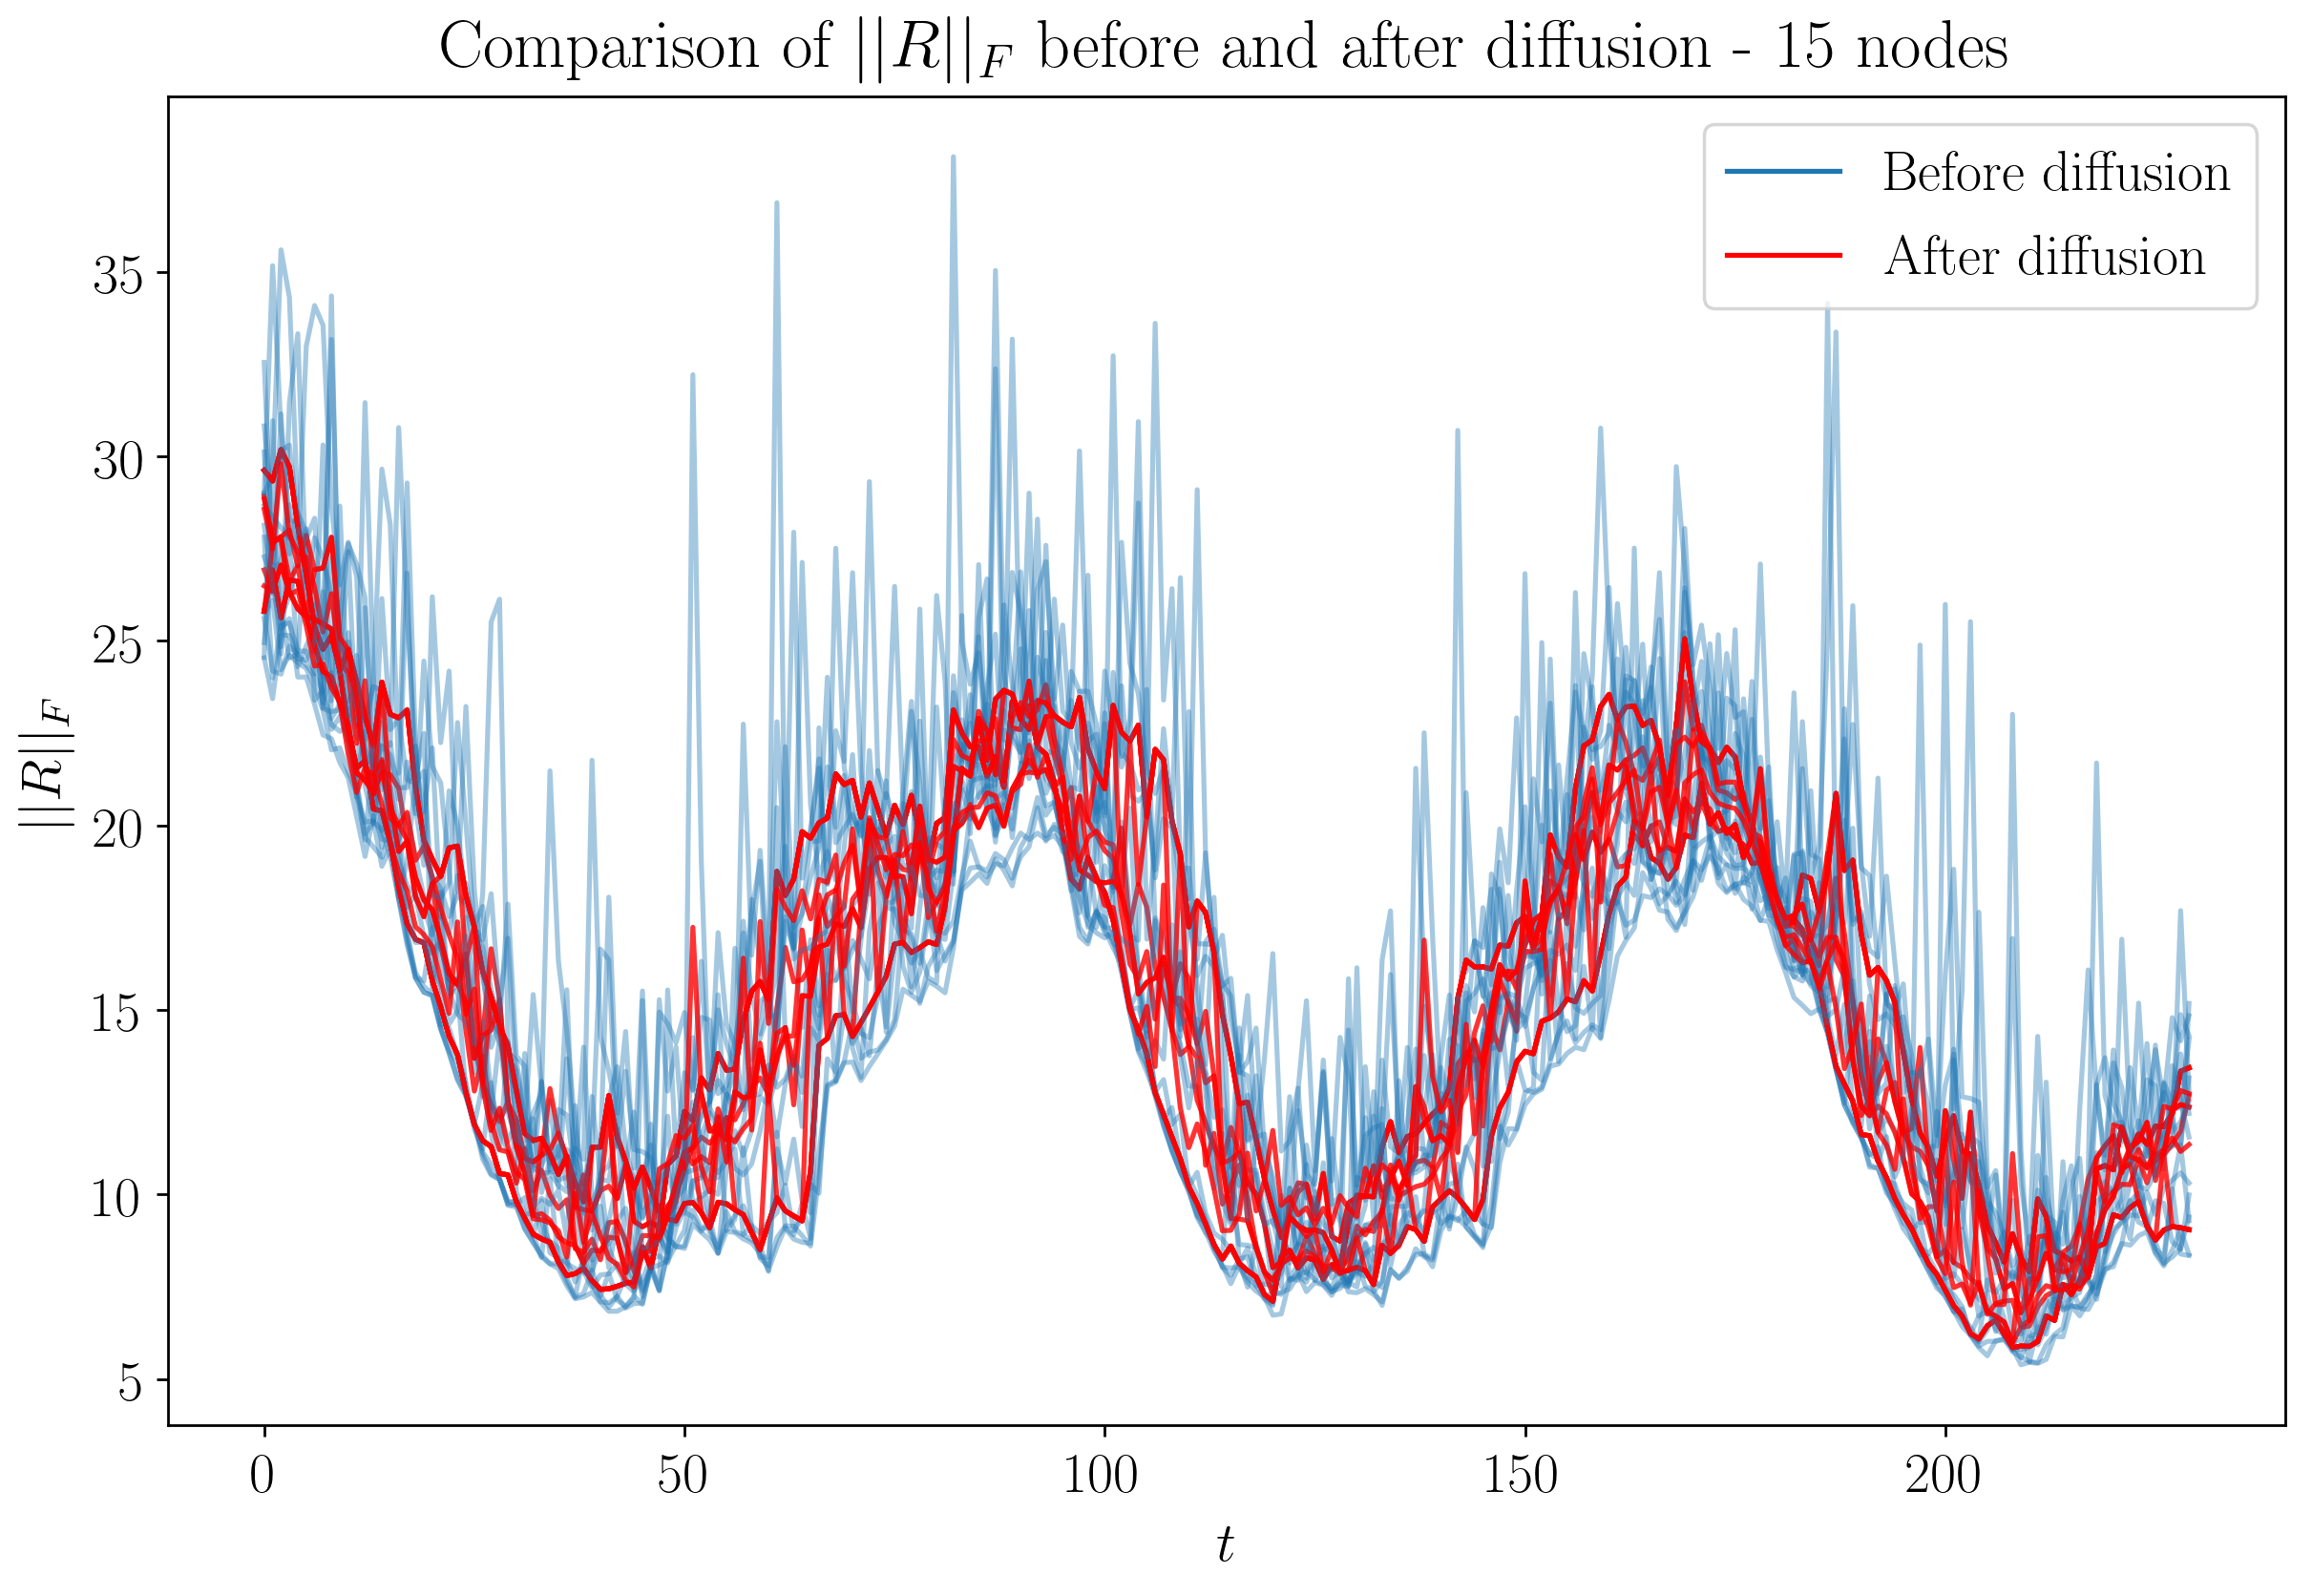

In [111]:
for nd in list(G.nodes):
    xs = [np.linalg.norm(x) for x in nd.logger['R']][20:]
    xspost = [np.linalg.norm(x) for x in nd.logger['R_post']][20:]
    plt.plot(xs, color='#1f77b4', alpha=0.4)
    plt.plot(xspost, color='r', alpha=0.8)

plt.plot(xs[0], color='#1f77b4', label='Before diffusion')
plt.plot(xs[0], color='r', label='After diffusion')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$||R||_F$')
plt.title('Comparison of $||R||_F$ before and after diffusion - 15 nodes')
savef('compare-mult-nodes-r-diff.pdf')

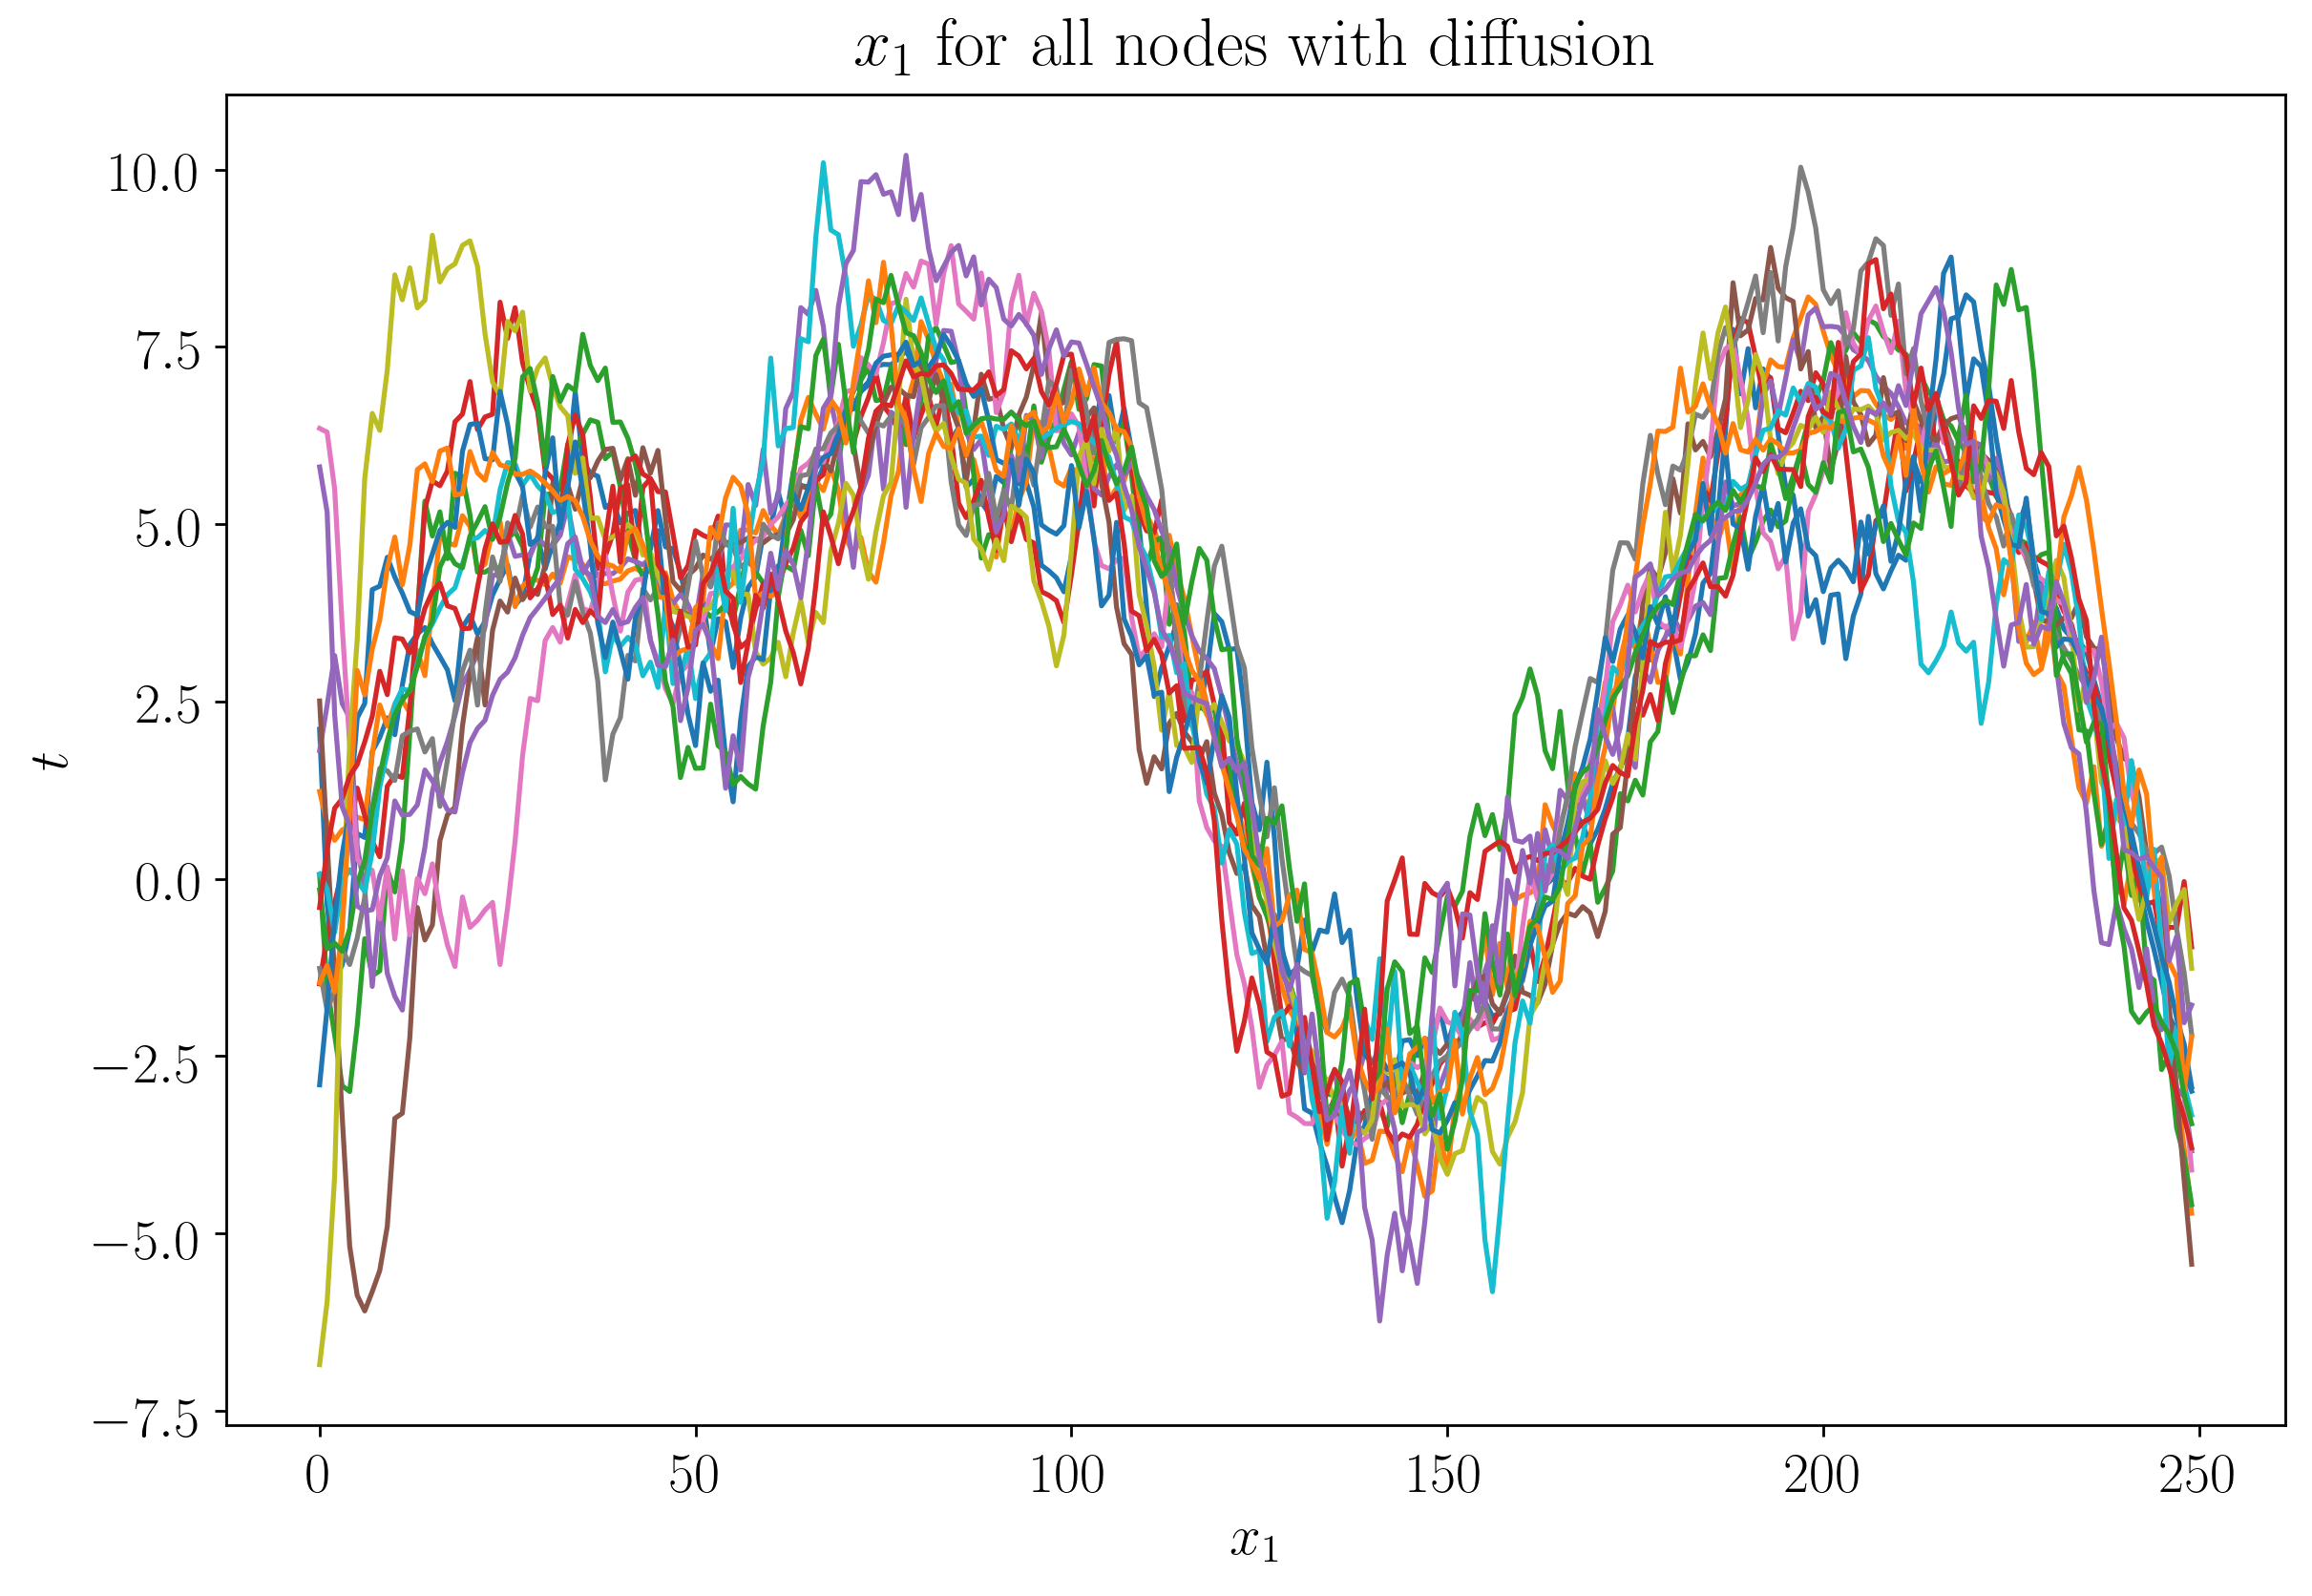

In [112]:
for nd in list(G.nodes):
    xs = np.array(nd.logger['x'])[:, 0]
    plt.plot(xs)
    
plt.title('$x_1$ for all nodes with diffusion')
plt.xlabel('$x_1$')
plt.ylabel('$t$')
savef('all-nodes-diffusion-x1.pdf')

In [113]:
G_n = create_w_nodes(NODES, trj,  cov_init, 1)
G_n.kf_no_diffusion(trj.X)

(array([1.6772, 1.1121, 1.6889, 1.2615]),
 array([1.9136, 1.1764, 1.8903, 1.2969]))

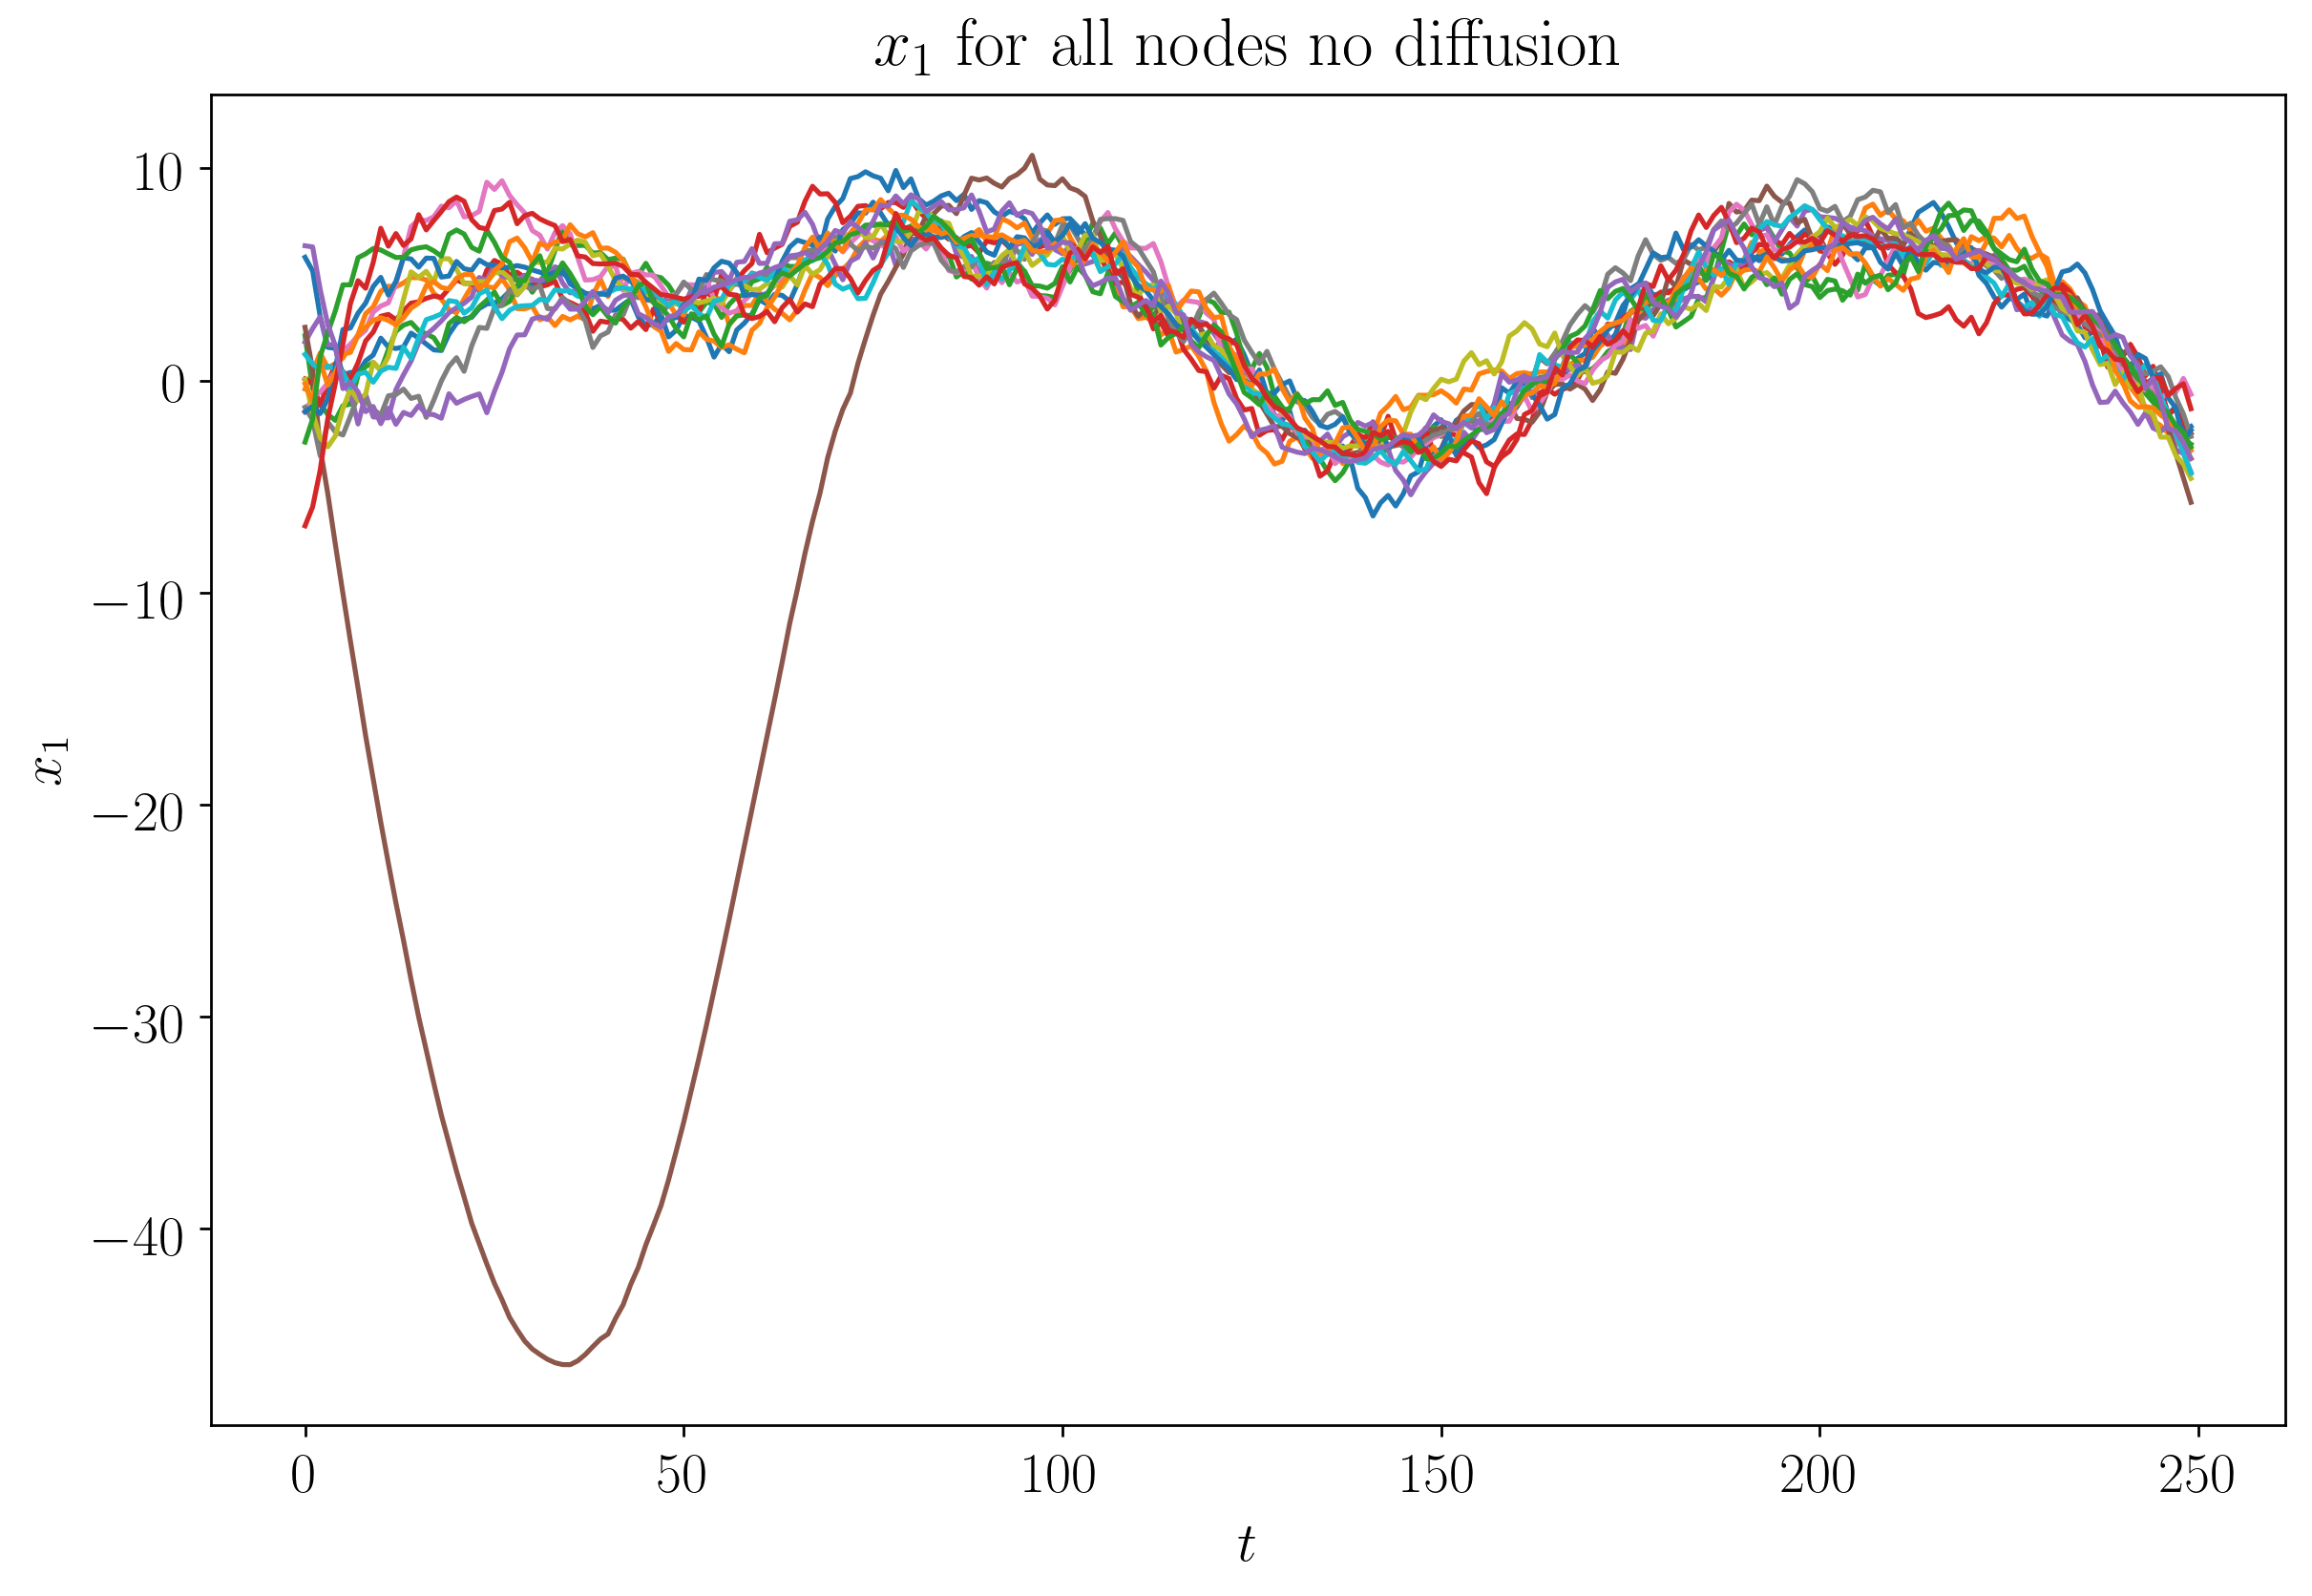

In [123]:
for nd in list(G_n.nodes):
    xs = np.array(nd.logger['x'])[:, 0]
    plt.plot(xs)

plt.title('$x_1$ for all nodes no diffusion')
plt.ylabel('$x_1$')
plt.xlabel('$t$')
savef('all-nodes-no-diff-x1.pdf')

# Covariance for non vs w all nodes

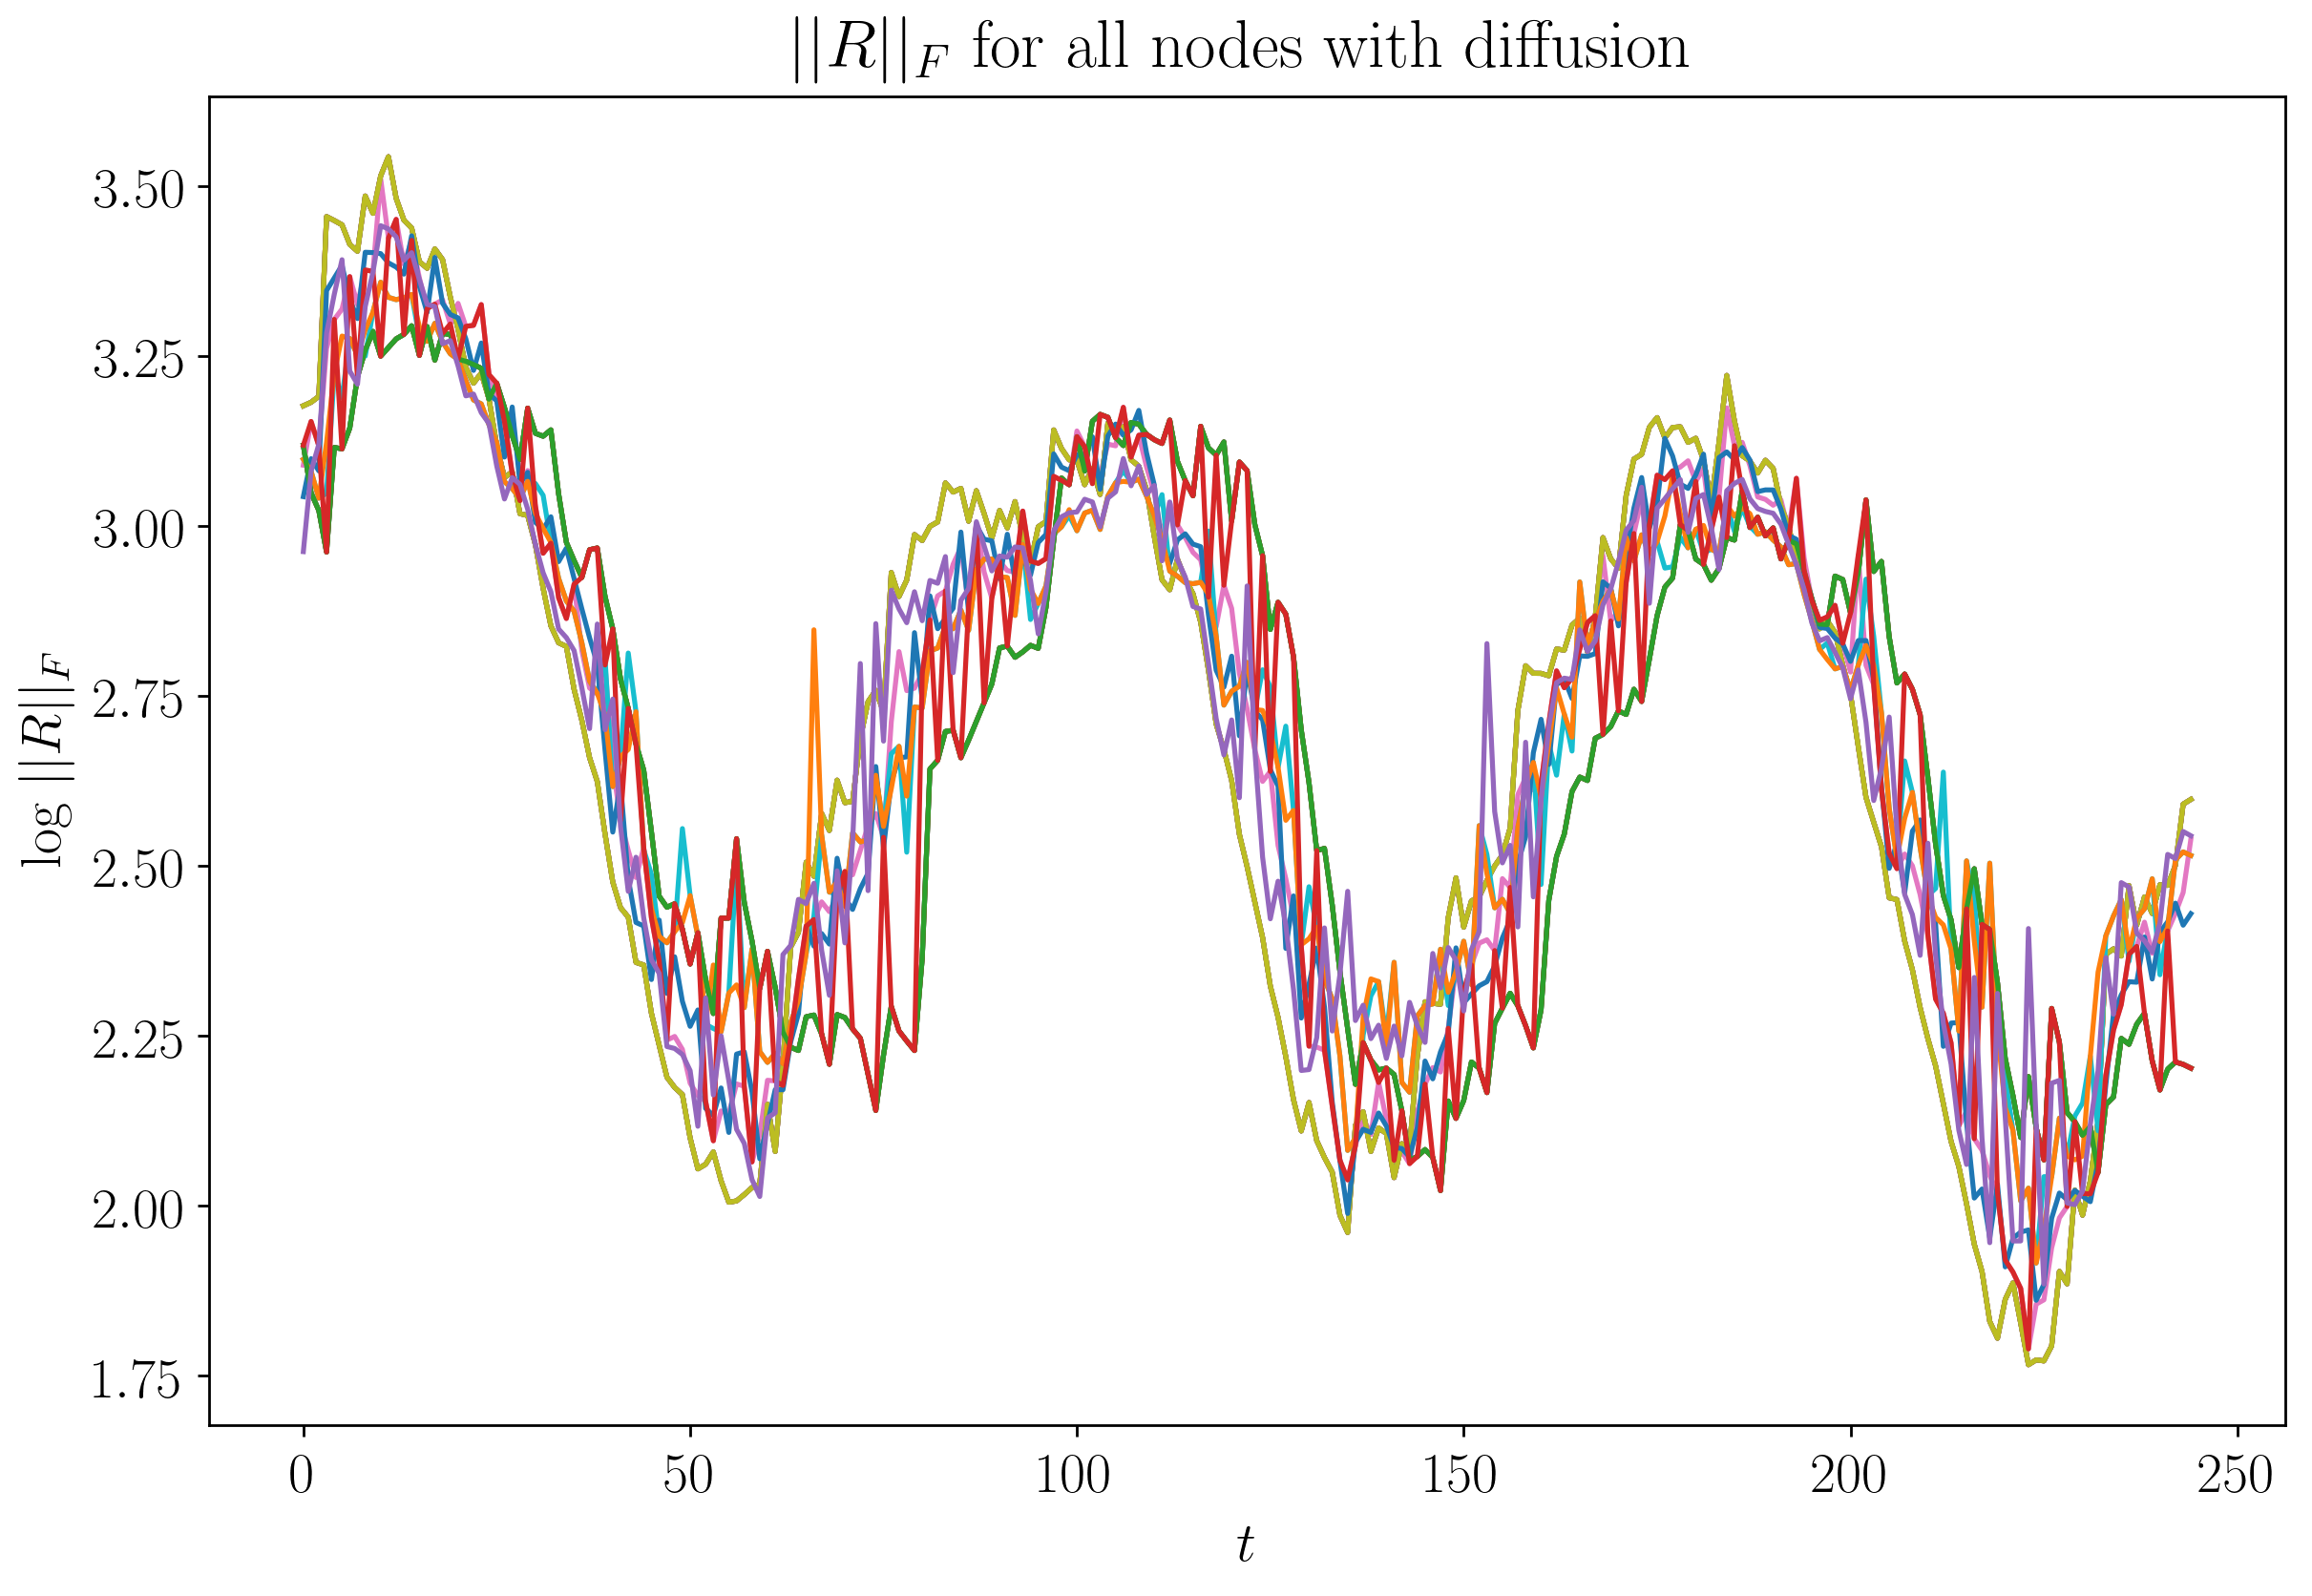

In [121]:
for nd in list(G.nodes):
    xs = [np.linalg.norm(x) for x in nd.logger['R_post']][5:]
    plt.plot(np.log(xs))
    #plt.plot(ys, label=f'{nd} - observation')
    
#plt.plot(true_traj[:, 0])
#plt.legend()
plt.title('$||R||_F$ for all nodes with diffusion')
plt.ylabel('log $||R||_F$')
plt.xlabel('$t$')
savef('log-r-all-nodes-diff.pdf')

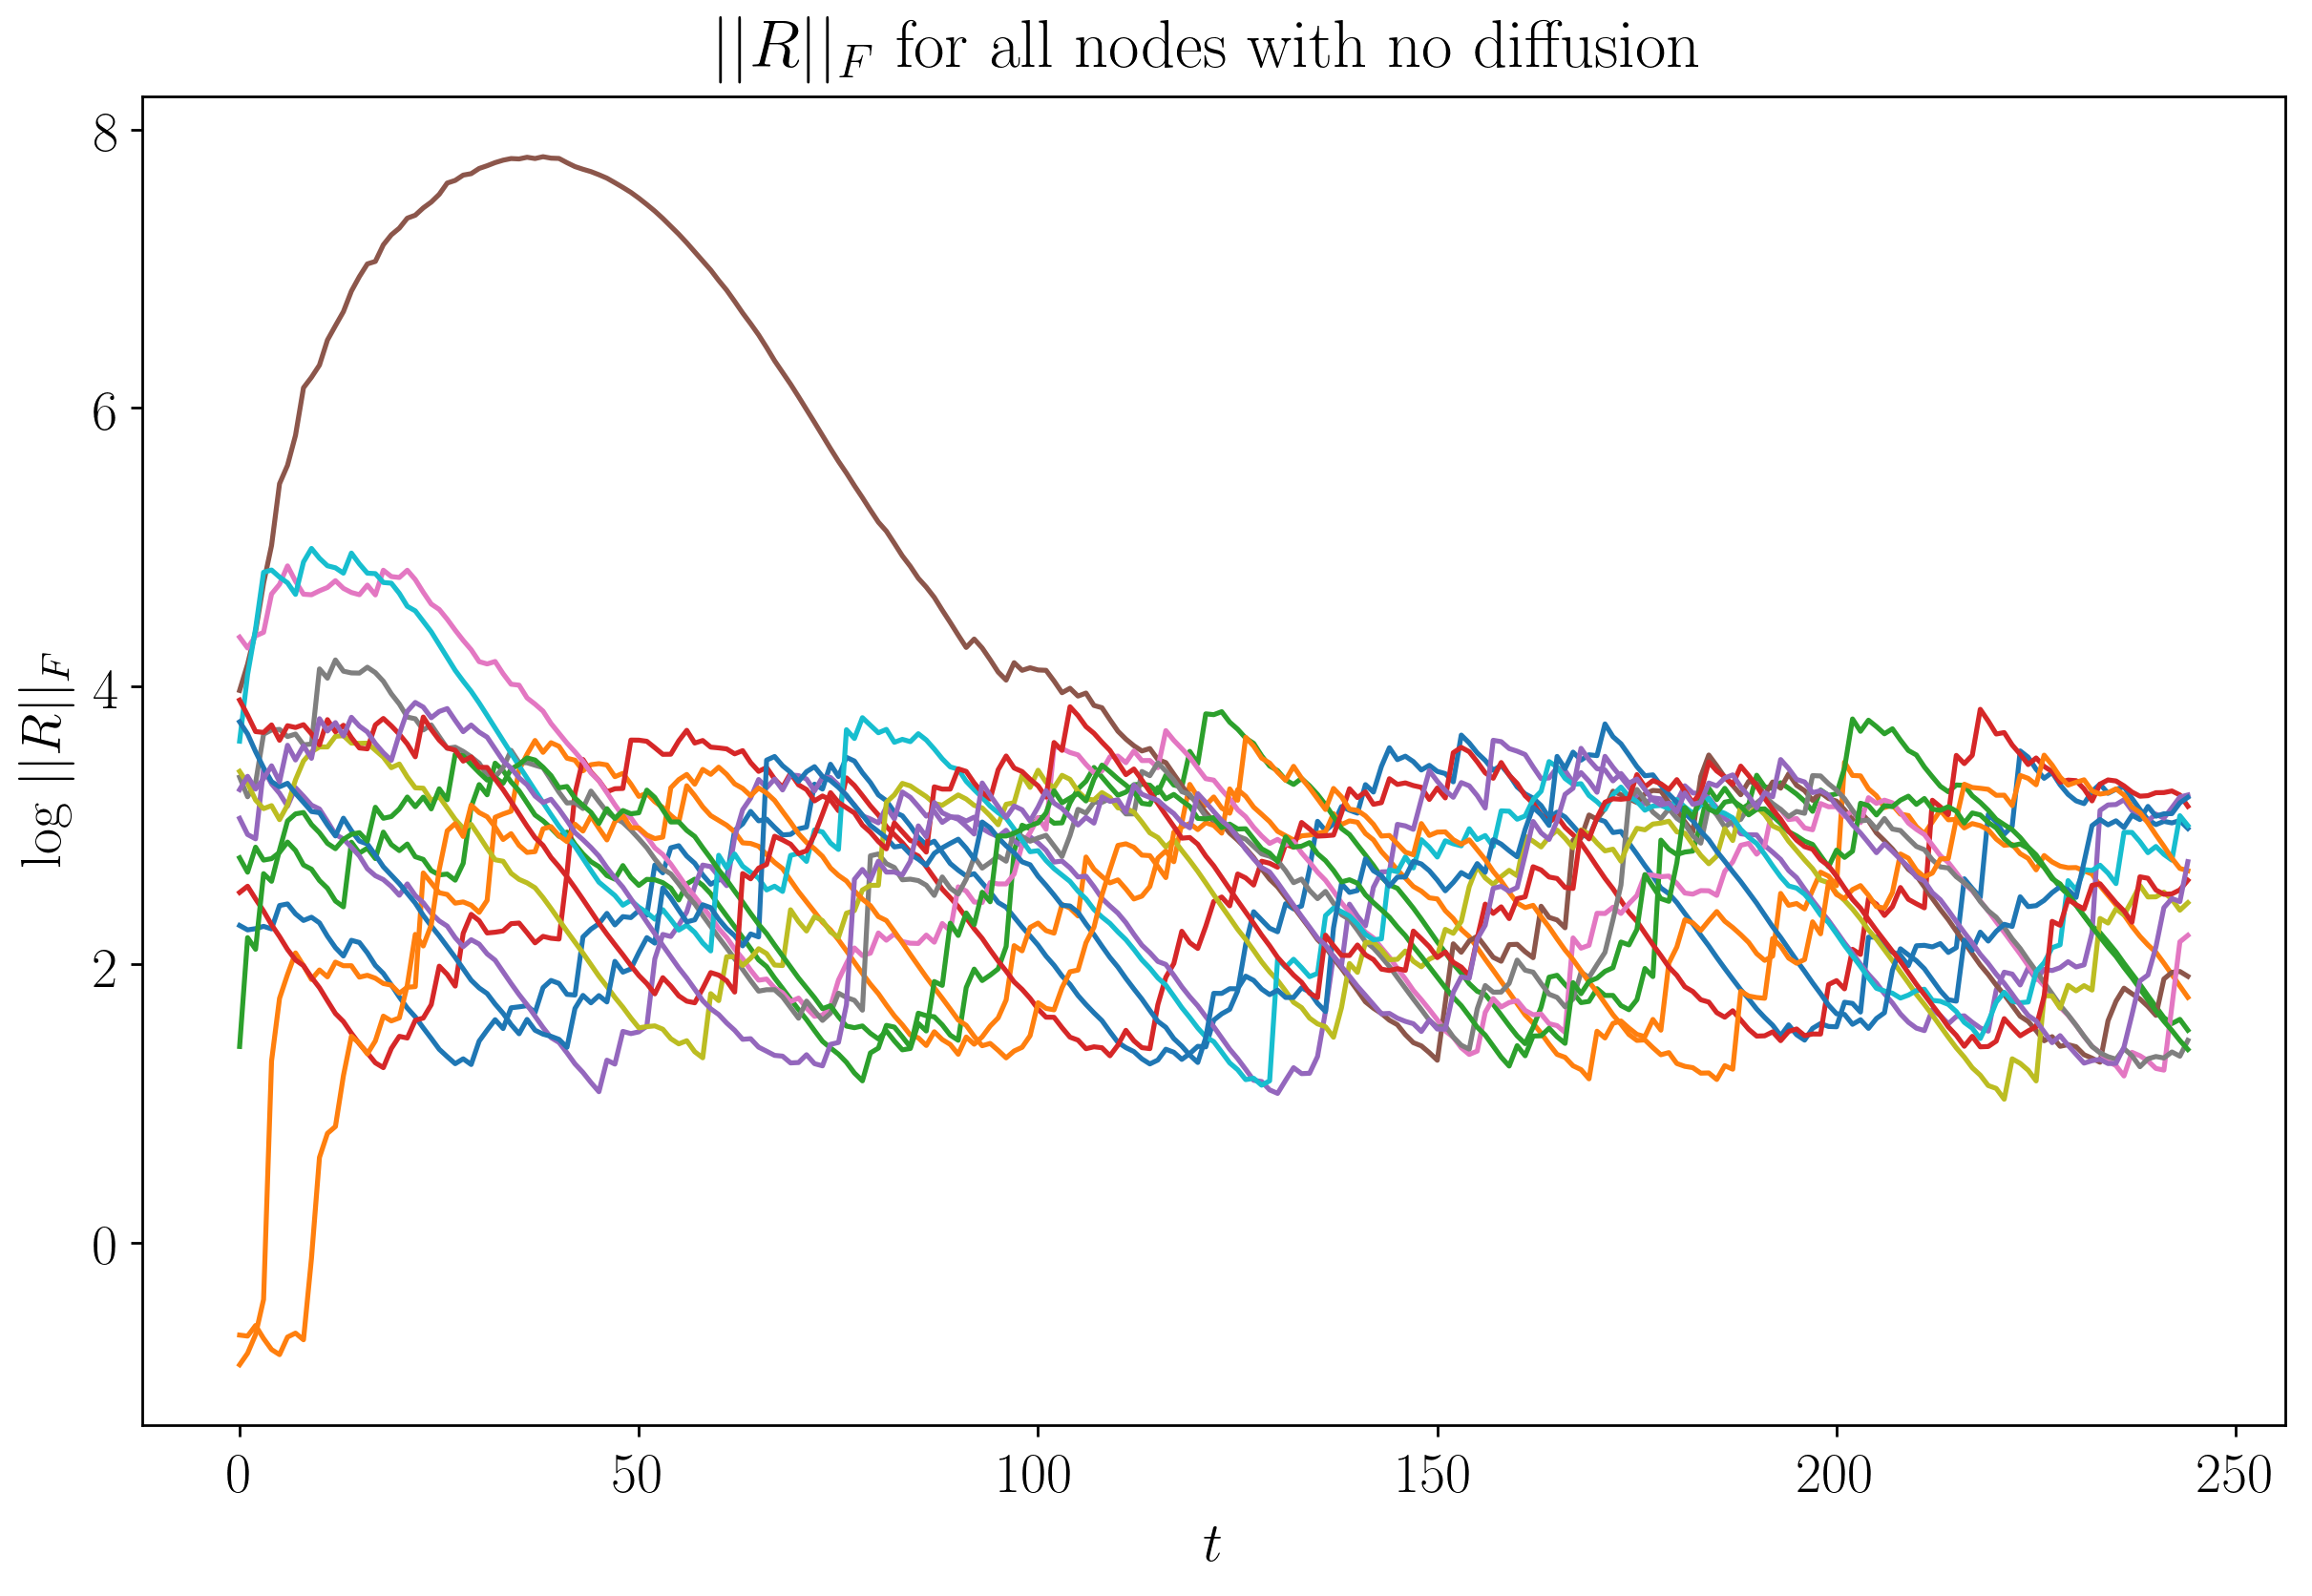

In [122]:
for nd in list(G_n.nodes):
    xs = [np.linalg.norm(x) for x in nd.logger['R']][5:]
    ys = [x[0] for x in nd.logger['y']]
    plt.plot(np.log(xs))

plt.title('$||R||_F$ for all nodes with no diffusion')
plt.ylabel('log $||R||_F$')
plt.xlabel('$t$')
savef('log-r-all-nodes-nodiff.pdf')

# Multiple rows nodes

In [34]:
for i in [10, 15, 30]:
    nodiff_G = create_w_nodes(i, trj,  cov_init)
    print(i)
    print(nodiff_G.kf_no_diffusion(true_traj.T))

10
(array([0.9152, 0.865 , 1.3597, 1.1531]), array([0.7833, 0.7878, 1.5281, 1.0057]))
15
(array([1.3309, 0.9124, 1.5544, 1.1643]), array([1.4993, 0.8837, 1.8263, 1.0483]))
30
(array([1.1059, 0.9517, 1.4108, 1.2677]), array([1.1269, 0.9215, 1.5407, 1.3646]))


In [35]:
nodiff_G = create_w_nodes(NODES, trj,  cov_init)
nodiff_G.kf_no_diffusion(true_traj.T)

(array([1.3309, 0.9124, 1.5544, 1.1643]),
 array([1.4993, 0.8837, 1.8263, 1.0483]))

Se zpětnou vazbou několikrát je to lepší než když tam mám `- cluster`

In [36]:
for i in [10, 14, 30]:
    diff_G = create_w_nodes(i, trj, cov_init)
    print(i)
    print(diff_G.kf_w_diffusion(true_traj.T))

10
(array([0.9027, 0.8516, 1.3534, 1.1397]), array([0.7623, 0.7376, 1.4913, 0.9927]))
14
(array([0.957 , 0.8404, 1.3825, 1.1359]), array([0.8654, 0.7263, 1.5489, 0.9976]))
30
(array([0.9044, 0.8954, 1.325 , 1.2549]), array([0.7773, 0.7884, 1.4486, 1.3868]))


Bez zpětné vazby:

In [37]:
for i in [10, 14, 30]:
    diff_G = create_w_nodes(i, trj, cov_init)
    print(i)
    print(diff_G.kf_w_diffusion(true_traj.T))

10
(array([0.9107, 0.8499, 1.347 , 1.1366]), array([0.7874, 0.741 , 1.4966, 0.9741]))
14
(array([0.9163, 0.8356, 1.3553, 1.1456]), array([0.767 , 0.7326, 1.5139, 1.0352]))
30
(array([0.9159, 0.8843, 1.3395, 1.2458]), array([0.7874, 0.7922, 1.4789, 1.3731]))


In [38]:
for i in [10, 15, 30]:
    diff_G = create_w_nodes(i, trj, cov_init)
    print(i)
    print(diff_G.kf_w_diffusion(true_traj.T))

10
(array([0.9013, 0.8491, 1.3367, 1.1351]), array([0.7704, 0.7345, 1.4428, 0.9724]))
15
(array([0.9929, 0.8515, 1.4438, 1.1476]), array([0.896 , 0.7303, 1.7059, 1.024 ]))
30
(array([0.9095, 0.8843, 1.3239, 1.2426]), array([0.7775, 0.7793, 1.4564, 1.3666]))
